In [1]:
!pip install -U "mostlyai"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.7/229.7 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 45.6 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


# Close Gaps in Your Data with Smart Imputation

Dealing with datasets that contain missing values can be a challenge. This is especially so if the remaining non-missing values are not representative and thus provide a distorted, biased picture of the overall population.

In this tutorial we demonstrate how MOSTLY AI can help to close such gaps in your data via "Smart Imputation". By generating a synthetic dataset that doest not contain any missing values, it is possible to create a complete and sound representation of the underlying population. With this smartly imputed synthetic dataset it is then straightforward to accurately analyze the population as if all values were present in the first place.

For this tutorial, we will be using a modified version of the UCI Adult Income dataset, that itself stems from the 1994 American Community Survey by the US census bureau. This reduced dataset consists of 48,842 records and 10 mixed-type features. We will replace ~30% of the values for attribute `age` with missing values. We will do this randomly, but with a specified bias, so that we end up missing the age information particularly from the elder segments.

## Data Preparation for this Tutorial

We start by artificially injecting missing values into the original data via the following code.

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('https://github.com/mostly-ai/public-demo-data/raw/dev/census/census.csv.gz')

def mask(prob, col=None, values=None):
    is_masked = np.random.uniform(size=df.shape[0]) < prob
    if col:
        is_masked = (is_masked) & (df[col].isin(values))
    df['age'] = df['age'].mask(is_masked)

np.random.seed(123)
mask(0.1, 'age', [51+i for i in range(20)])
mask(0.2, 'age', [71+i for i in range(20)])
mask(0.6, 'income', ['>50K'])
mask(0.6, 'education', ['Doctorate', 'Prof-school', 'Masters'])
mask(0.6, 'marital_status', ['Widowed', 'Divorced'])
mask(0.6, 'occupation', ['Exec-managerial'])
mask(0.6, 'workclass', ['Self-emp-inc'])
tgt=df
print(f'Created original data with missing values with {tgt.shape[0]:,} records and {tgt.shape[1]} attributes')

Created original data with missing values with 48,842 records and 15 attributes


In [3]:
# let's show some samples
tgt[['workclass', 'education', 'marital_status', 'age']].sample(n=10, random_state=42)

,workclass,education,marital_status,age
7762,Private,HS-grad,Never-married,18.0
23881,Private,12th,Never-married,17.0
30507,Local-gov,HS-grad,Never-married,25.0
28911,Private,Some-college,Never-married,20.0
19484,Private,HS-grad,Never-married,47.0
43031,Private,Bachelors,Married-civ-spouse,33.0
28188,Private,HS-grad,Married-civ-spouse,38.0
12761,Private,11th,Married-civ-spouse,21.0
40834,Private,Assoc-acdm,Divorced,NaN
27875,Private,HS-grad,Married-civ-spouse,55.0


In [4]:
# report share of missing values for column `age`
print(f"{tgt['age'].isna().mean():.1%} of values for column `age` are missing")

32.7% of values for column `age` are missing


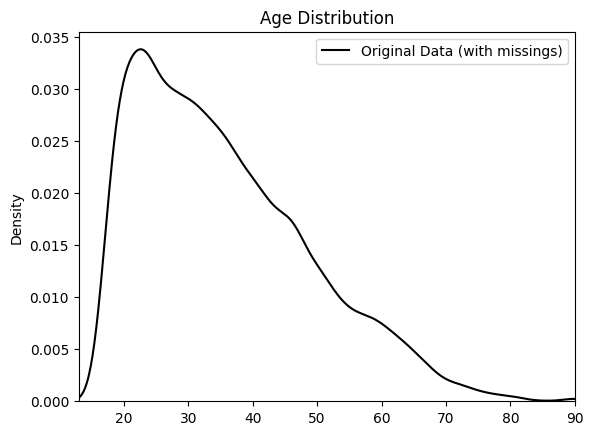

In [5]:
# plot distribution of column `age`
import matplotlib.pyplot as plt
tgt.age.plot(kind='kde', label = 'Original Data (with missings)', color='black')
_ = plt.legend(loc='upper right')
_ = plt.title('Age Distribution')
_ = plt.xlim(13, 90)
_ = plt.ylim(0, None)

## Synthesize Data via MOSTLY AI

The code below will automatically create a Generator using the MOSTLY AI Synthetic Data SDK. The we will use that Generator to create a Synthetic dataset with turned on Smart Imputation for the `age` column.

In [6]:
from mostlyai.sdk import MostlyAI
from google.colab import userdata

# initialize SDK
mostly = MostlyAI(local=False, api_key=userdata.get('MOSTLYAI_API_KEY'))  # or: MostlyAI(local=False, api_key='xxx')

Initializing Synthetic Data SDK 4.7.8 in CLIENT mode 📡

Connected to ]8;id=773063;https://app.mostly.ai\https://app.mostly.ai]8;;\ 4.7.2 as natanael.ahm@gmail.com

In [7]:
# train a generator on the original training data
g = mostly.train(data=tgt, name='Smart Imputation Tutorial - Census')

Created generator ]8;id=337153;https://app.mostly.ai/d/generators/1c984ba6-b1e4-4db2-80e2-534d723067cf\1c984ba6-b1e4-4db2-80e2-534d723067cf]8;;\

Started generator training

Output()

🎉 Your generator is ready! Use it to create synthetic data. Publish it so others can do the same.

In [8]:
# generate synthetic data with imputed age column
config = {
    'name': 'Smart Imputation Tutorial - Census',
    'tables': [
        {'name': 'data',
            'configuration': {
                'imputation': {
                    'columns': ['age']
                }
            }
        }
    ]
}
syn = mostly.generate(g, config=config).data()
print(f"Created synthetic data with {syn.shape[0]:,} records and {syn.shape[1]:,} attributes")

Created synthetic dataset ]8;id=870373;https://app.mostly.ai/d/synthetic-datasets/4b55f38d-c267-4545-8492-8b8cb8c8cc64\4b55f38d-c267-4545-8492-8b8cb8c8cc64]8;;\ with generator ]8;id=799026;https://app.mostly.ai/d/generators/1c984ba6-b1e4-4db2-80e2-534d723067cf\1c984ba6-b1e4-4db2-80e2-534d723067cf]8;;\

Started synthetic dataset generation

Output()

🎉 Your synthetic dataset is ready! Use it to consume the generated data. Publish it so others can do the same.

Created synthetic data with 48,842 records and 15 attributes


If you want to, you can now check the distribution based on the Model QA and Data QA reports. Download these via `sd.reports()`. The Model QA reports on the accuracy and privacy of the trained Generative AI model. As one can see, the distributiosn are faithfully learned, and also include the right share of missing values. The Data QA visualizes then the distributions of the delivered Synthetic dataset. And there we can see, that the share of missing values (`N/A`) has dropped to 0%, and that the distribution has been shifted towards older age buckets.

## Analyze the results

We can now explore the imputed synthetic data.

In [9]:
# show some synthetic samples
syn[['workclass', 'education', 'marital_status', 'age']].sample(n=10, random_state=42)

,workclass,education,marital_status,age
7762,Private,HS-grad,Never-married,26
23881,Private,Some-college,Never-married,24
30507,Private,Bachelors,Married-civ-spouse,39
28911,State-gov,Some-college,Married-civ-spouse,36
19484,Private,HS-grad,Married-civ-spouse,24
43031,Private,HS-grad,Married-civ-spouse,62
28188,Private,HS-grad,Never-married,47
12761,Private,Bachelors,Never-married,25
40834,Private,9th,Divorced,33
27875,State-gov,Doctorate,Married-civ-spouse,30


In [10]:
# report share of missing values for column `age`
print(f"{syn['age'].isna().mean():.1%} of values for column `age` are missing")

0.0% of values for column `age` are missing


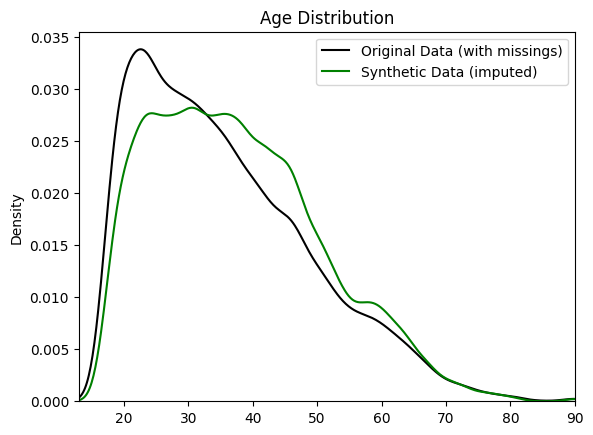

In [11]:
# plot side-by-side
import matplotlib.pyplot as plt
tgt.age.plot(kind='kde', label = 'Original Data (with missings)', color='black')
syn.age.plot(kind='kde', label = 'Synthetic Data (imputed)', color='green')
_ = plt.title('Age Distribution')
_ = plt.legend(loc='upper right')
_ = plt.xlim(13, 90)
_ = plt.ylim(0, None)

As one can see, the imputed synthetic data does NOT contain any missing values anymore. But it's also apparent, that the synthetic age distribution is significantly distinct from the distribution of the non-missing values that were provided.

So, let's then check, whether that new distribution is more representative of the ground truth, i.e. the underlying original age distribution.

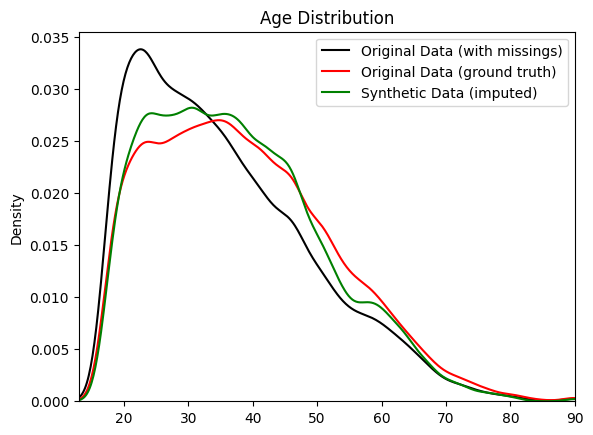

In [12]:
raw = pd.read_csv('https://github.com/mostly-ai/public-demo-data/raw/dev/census/census.csv.gz')

# plot side-by-side
import matplotlib.pyplot as plt
tgt.age.plot(kind='kde', label = 'Original Data (with missings)', color='black')
raw.age.plot(kind='kde', label = 'Original Data (ground truth)', color='red')
syn.age.plot(kind='kde', label = 'Synthetic Data (imputed)', color='green')
_ = plt.title('Age Distribution')
_ = plt.legend(loc='upper right')
_ = plt.xlim(13, 90)
_ = plt.ylim(0, None)

## Conclusion

As we can see, the smartly imputed synthetic data is perfectly able to recover the original, suppressed distribution! As an analyst you can proceed with the exploratory and descriptive analysis, as if the values were present in the first place.

## Further Reading

See also here for a benchmark of Smart Imputation with respect to other commonly used imputation techniques: https://mostly.ai/blog/smart-imputation-with-synthetic-data